In [66]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import efel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
efel.get_feature_names()

['ADP_peak_amplitude',
 'ADP_peak_indices',
 'ADP_peak_values',
 'AHP1_depth_from_peak',
 'AHP2_depth_from_peak',
 'AHP_depth',
 'AHP_depth_abs',
 'AHP_depth_abs_slow',
 'AHP_depth_diff',
 'AHP_depth_from_peak',
 'AHP_depth_slow',
 'AHP_slow_time',
 'AHP_time_from_peak',
 'AP1_amp',
 'AP1_begin_voltage',
 'AP1_begin_width',
 'AP1_peak',
 'AP1_width',
 'AP2_AP1_begin_width_diff',
 'AP2_AP1_diff',
 'AP2_AP1_peak_diff',
 'AP2_amp',
 'AP2_begin_voltage',
 'AP2_begin_width',
 'AP2_peak',
 'AP2_width',
 'AP_amplitude',
 'AP_amplitude_change',
 'AP_amplitude_diff',
 'AP_amplitude_from_voltagebase',
 'AP_begin_indices',
 'AP_begin_time',
 'AP_begin_voltage',
 'AP_begin_width',
 'AP_duration',
 'AP_duration_change',
 'AP_duration_half_width',
 'AP_duration_half_width_change',
 'AP_end_indices',
 'AP_fall_indices',
 'AP_fall_rate',
 'AP_fall_rate_change',
 'AP_fall_time',
 'AP_height',
 'AP_peak_downstroke',
 'AP_peak_upstroke',
 'AP_phaseslope',
 'AP_rise_indices',
 'AP_rise_rate',
 'AP_rise_ra

In [ ]:
print(efel.get_settings())

Threshold: -20.0
DerivativeThreshold: 10.0
DownDerivativeThreshold: -12.0
dependencyfile_path: /Users/han.hou/miniconda3/envs/patch-seq/lib/python3.10/site-packages/efel/DependencyV5.txt
spike_skipf: 0.1
max_spike_skip: 2
interp_step: 0.1
burst_factor: 1.5
strict_burst_factor: 2.0
voltage_base_start_perc: 0.9
voltage_base_end_perc: 1.0
current_base_start_perc: 0.9
current_base_end_perc: 1.0
rise_start_perc: 0.0
rise_end_perc: 1.0
initial_perc: 0.1
min_spike_height: 20.0
strict_stiminterval: False
initburst_freq_threshold: 50
initburst_sahp_start: 5
initburst_sahp_end: 100
DerivativeWindow: 3
voltage_base_mode: mean
current_base_mode: mean
precision_threshold: 1e-10
sahp_start: 5.0
ignore_first_ISI: True
impedance_max_freq: 50.0
AP_phaseslope_range: 2
inactivation_tc_end_skip: 10


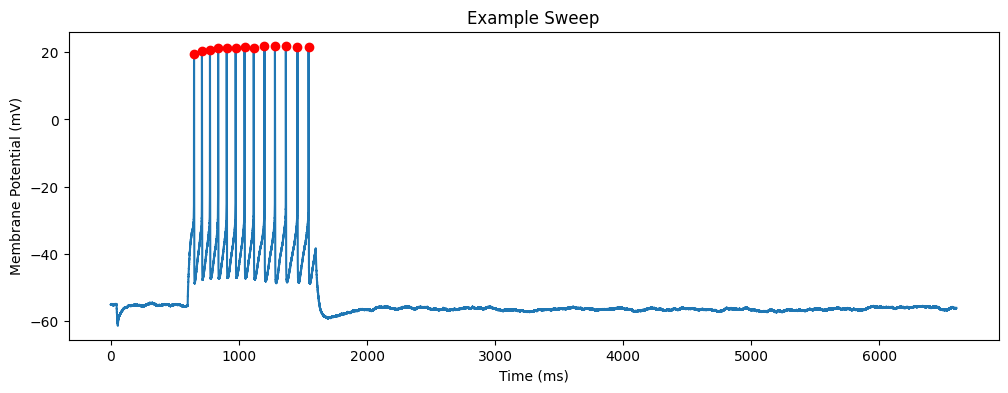

In [53]:
from LCNE_patchseq_analysis.data_util.nwb import PatchSeqNWB

sweep_number = 129

# Load an example NWB file
raw = PatchSeqNWB(ephys_roi_id="1408897096")

# Get trace and time for sweep 0 
trace = raw.get_raw_trace(sweep_number)
time = raw.dt_ms * np.arange(len(trace))
start_time = raw.df_sweeps.query("sweep_number == @sweep_number")["stimulus_start_time"].values[0]
end_time = start_time + raw.df_sweeps.query("sweep_number == @sweep_number")["stimulus_duration"].values[0]

# Use efel to get features
traces = [
    {
        "T": time,
        "V": trace,
        "stim_start": [0],
        "stim_end": [3000],
    }
]
df_features = pd.DataFrame(efel.get_feature_values(traces, efel.get_feature_names(), raise_warnings=False))

# Plot the trace
plt.figure(figsize=(12,4))
plt.plot(time, trace)
plt.plot(df_features["peak_time"][0], df_features["peak_voltage"][0], "ro")
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Example Sweep')
plt.show()


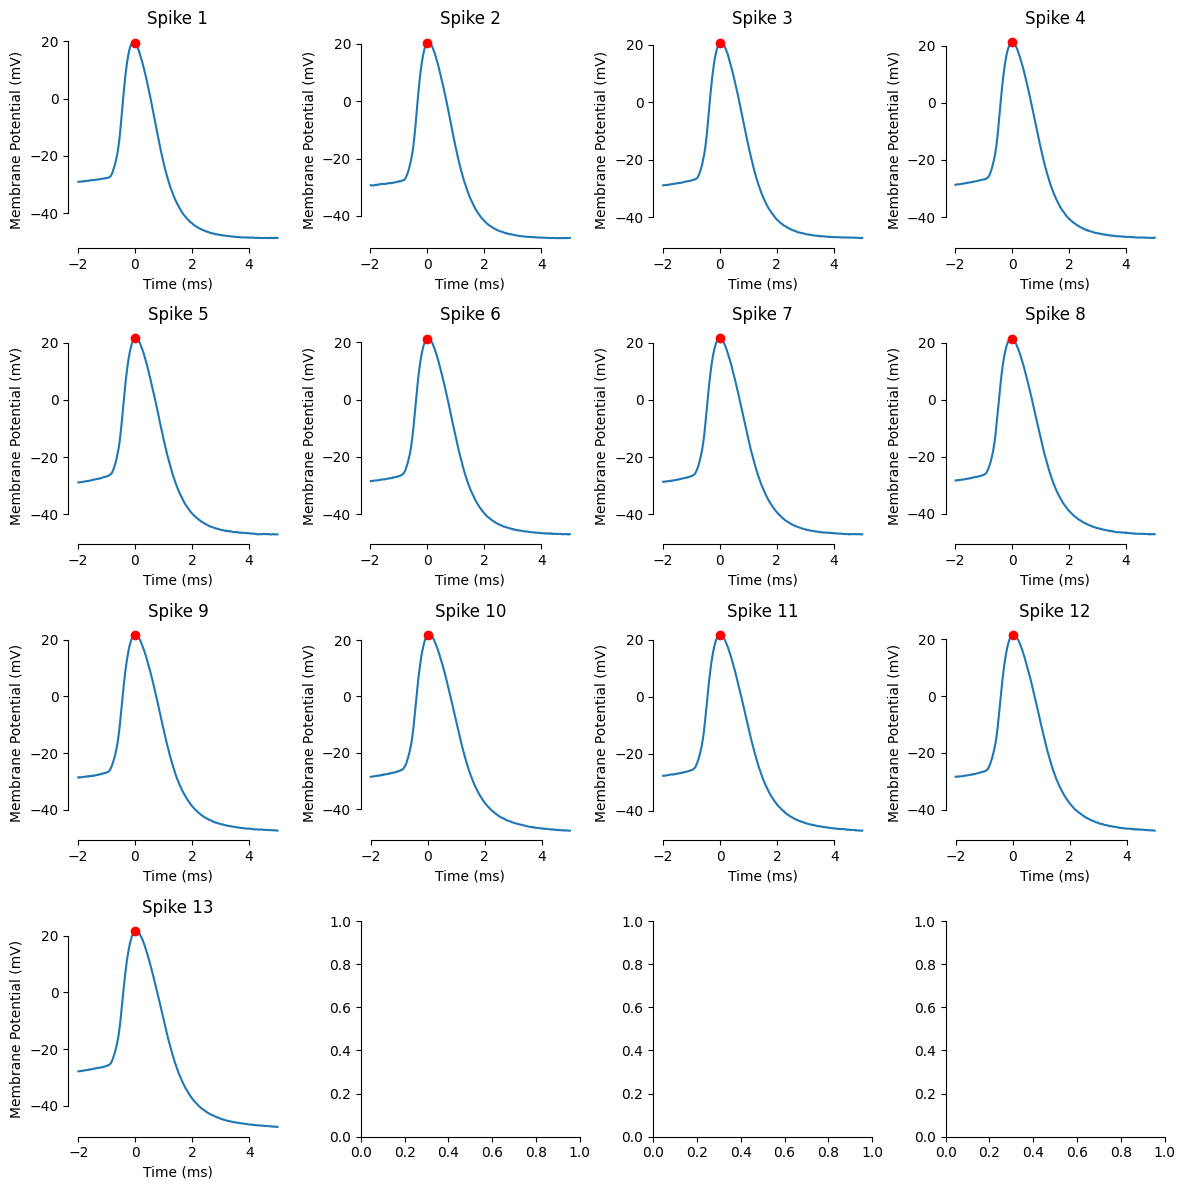

In [86]:
# Plot individual spikes overlaid with some features

peak_times = df_features["peak_time"][0]
n_spikes = len(peak_times)
n_rows = int(np.floor(np.sqrt(n_spikes))) + 1
n_cols = int(np.ceil(np.sqrt(n_spikes)))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

window = [-2, 5]  # Time window around a spike

for i, peak_time in enumerate(peak_times):
    ax = axs.flatten()[i]
    
    # Get the trace around the spike
    start_time = peak_time + window[0]
    end_time = peak_time + window[1]
    idx = np.where((time >= start_time) & (time <= end_time))[0]
    time_this = time[idx] - peak_time  # Center the time on the spike
    trace_this = trace[idx]
    
    # Overlay features
    ax.plot(time_this, trace_this)
    
    ax.plot(df_features["peak_time"][0][i] - peak_time, df_features["peak_voltage"][0][i], "ro")
    
    # For 1D array or single subplot
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Membrane Potential (mV)')
    ax.set_title(f'Spike {i+1}')

fig.tight_layout()
sns.despine(trim=True)


In [26]:
raw.df_sweeps.query("sweep_number == 129")["stimulus_start_time"]

100    0.6
Name: stimulus_start_time, dtype: float64